In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [51]:
df_target = pd.read_csv("power_consumption_g3.csv")

In [52]:
df_target["Date"] = pd.to_datetime(df_target["Date"])
df_target.set_index(keys=["Date"], inplace=True)
df_target.sort_index(inplace=True)

df_target.head()

,SolarPower
Date,
2017-01-01 00:00:00,34055.69620
2017-01-01 00:10:00,29814.68354
2017-01-01 00:20:00,29128.10127
2017-01-01 00:30:00,28228.86076
2017-01-01 00:40:00,27335.69620


In [53]:
df_features = pd.read_csv("power_consumption_g3_feat.csv")

In [54]:
df_features["Date"] = pd.to_datetime(df_features["Date"])
df_features.set_index(keys=["Date"], inplace=True)
df_features.sort_index(inplace=True)

df_features.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Date,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085


In [55]:
df = pd.merge(left=df_features, right=df_target, left_index=True, right_index=True)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


In [56]:
features = ["Temperature", "Humidity", "WindSpeed", "GeneralDiffuseFlows", "DiffuseFlows"]
target = "SolarPower"

In [57]:
for feature in features:
    df[feature] = df[feature].interpolate(method="time")

In [58]:
df = df.groupby(pd.Grouper(freq="2h")).mean()
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower
Date,,,,,,
2017-01-01 00:00:00,5.866833,76.300000,0.081917,0.060167,0.105667,26927.594937
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872


In [59]:
lags = range(4,0,-1)
list(lags)

for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
        
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,Temperature_4,Humidity_4,WindSpeed_4,GeneralDiffuseFlows_4,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,SolarPower_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,SolarPower_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,5.866833,76.300000,0.081917,0.060167,0.105667,26927.594937,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.866833,76.300000,0.081917,0.060167,0.105667,26927.594937
2017-01-01 04:00:00,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987,NaN,NaN,NaN,NaN,...,0.081917,0.060167,0.105667,26927.594937,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607
2017-01-01 06:00:00,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545,NaN,NaN,NaN,NaN,...,0.082583,0.061417,0.135083,21447.088607,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987
2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872,5.866833,76.3,0.081917,0.060167,...,0.081667,0.061917,0.120833,20641.518987,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545


In [60]:
df.dropna(axis=0, inplace=True)

In [61]:
df.drop(columns=features,inplace=True)

In [62]:
df.head()

,SolarPower,Temperature_4,Humidity_4,WindSpeed_4,GeneralDiffuseFlows_4,DiffuseFlows_4,SolarPower_4,Temperature_3,Humidity_3,WindSpeed_3,...,WindSpeed_2,GeneralDiffuseFlows_2,DiffuseFlows_2,SolarPower_2,Temperature_1,Humidity_1,WindSpeed_1,GeneralDiffuseFlows_1,DiffuseFlows_1,SolarPower_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 08:00:00,21255.189872,5.866833,76.300000,0.081917,0.060167,0.105667,26927.594937,5.029333,78.008333,0.082583,...,0.081667,0.061917,0.120833,20641.518987,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545
2017-01-01 10:00:00,27986.835442,5.029333,78.008333,0.082583,0.061417,0.135083,21447.088607,4.919667,74.641667,0.081667,...,0.082417,0.063583,0.122500,20094.683545,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872
2017-01-01 12:00:00,30060.759495,4.919667,74.641667,0.081667,0.061917,0.120833,20641.518987,4.512750,74.575000,0.082417,...,0.082417,79.281917,15.761833,21255.189872,8.019333,63.835833,2.913333,350.887500,34.108333,27986.835442
2017-01-01 14:00:00,29558.481012,4.512750,74.575000,0.082417,0.063583,0.122500,20094.683545,4.632167,73.791667,0.082417,...,2.913333,350.887500,34.108333,27986.835442,15.263333,57.075000,0.076167,486.391667,40.981667,30060.759495
2017-01-01 16:00:00,31576.708860,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872,8.019333,63.835833,2.913333,...,0.076167,486.391667,40.981667,30060.759495,15.662500,56.914167,0.075667,377.458333,48.125000,29558.481012


In [63]:
x,y = df.drop(columns=["SolarPower"]), df["SolarPower"]

In [64]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,shuffle=False)
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size=0.2,shuffle=False)

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [66]:
lag= 4

train_x = train_x.reshape(train_x.shape[0], lag, (train_x.shape[1] // lag))
val_x = val_x.reshape(val_x.shape[0], lag, (val_x.shape[1] // lag))
test_x = test_x.reshape(test_x.shape[0], lag, (test_x.shape[1] // lag))

In [67]:
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

C:\Users\kvasi\AppData\Local\Temp\ipykernel_26348\385664833.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_y = torch.tensor(train_y, dtype=torch.float32)
C:\Users\kvasi\AppData\Local\Temp\ipykernel_26348\385664833.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_y = torch.tensor(val_y, dtype=torch.float32)
C:\Users\kvasi\AppData\Local\Temp\ipykernel_26348\385664833.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [68]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

In [69]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [70]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(6, 64, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), 
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        return self.net(x)


In [71]:
model = CNNRegressor()

In [72]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [73]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    
    total_loss = 0
    for features, targets in dataloader:
        features, targets = features, targets
        optimizer.zero_grad()
        outputs = model(features).squeeze(-1)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss

In [74]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    
    total_loss, predictions = 0, []
    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features, targets
            outputs = model(features).squeeze(-1)
            loss = loss_fn(outputs, targets)
            predictions.extend(outputs.tolist())
            total_loss += loss.item()
            
    return total_loss, predictions

In [75]:
num_epochs=350

In [76]:
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss, pred_y = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        
        mape = mean_absolute_percentage_error(val_y.tolist(), pred_y)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch:3d}/{num_epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} mape={mape:.4f}")
    
    return train_losses, val_losses

In [77]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Epoch  50/350 | train_loss=1140345507.0000 val_loss=348060209.0000 mape=0.0891
Epoch 100/350 | train_loss=758260753.7500 val_loss=244778528.2500 mape=0.0700
Epoch 150/350 | train_loss=591176586.5000 val_loss=200265049.7500 mape=0.0648
Epoch 200/350 | train_loss=480793466.0000 val_loss=170966985.2500 mape=0.0627
Epoch 250/350 | train_loss=417553918.2500 val_loss=151964465.5000 mape=0.0601
Epoch 300/350 | train_loss=373782096.3750 val_loss=136113050.0000 mape=0.0571
Epoch 350/350 | train_loss=339047853.1250 val_loss=123220102.2500 mape=0.0547


<Axes: >

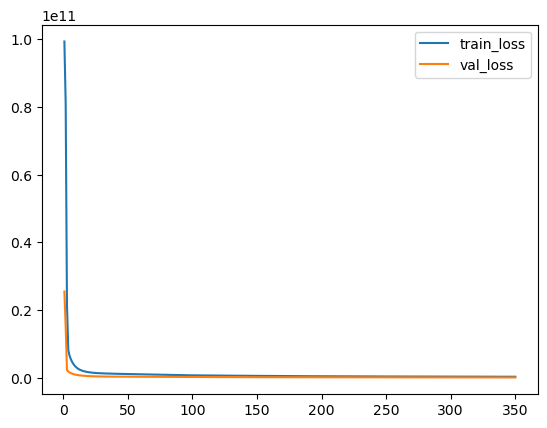

In [78]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [79]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn)

In [80]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 1910.0640974012028
MAPE: 0.06855212009783916
MSE: 5725699.612080166
RMSE: 2392.8434157044558
R2 Score: 0.8399080991144163
